# Lending Club Case Study

In [1]:
import numpy as np               # importing Numpy library built in C language for the Maths operation
import pandas as pd              # importing Pandas library build on top of numpy for huge operation on datasets
import matplotlib.pyplot as plt  # library to plot charts
import seaborn as sns            # library for presentatble graphical representation

### Data Loading and understanding

###### loading the data file 

In [2]:
#Loading the data file
loan_data = pd.read_csv("loan.csv")

#number of data points in the dataset
# loan_data.dtypes
loan_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39717 entries, 0 to 39716
Columns: 111 entries, id to total_il_high_credit_limit
dtypes: float64(74), int64(13), object(24)
memory usage: 33.6+ MB


C:\Users\Anurag\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (47) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


### Data Processing

###### dropping the row data which has the details for the current loan users

In [3]:
loan_data.drop(loan_data[(loan_data.loan_status=="Current")].index, inplace=True)

loan_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38577 entries, 0 to 39716
Columns: 111 entries, id to total_il_high_credit_limit
dtypes: float64(74), int64(13), object(24)
memory usage: 33.0+ MB


#### Dropping the columns which has either no value or NaN(NA) more than the threshold of 50%


In [4]:
loan_data.isna().sum()

id                                0
member_id                         0
loan_amnt                         0
funded_amnt                       0
funded_amnt_inv                   0
                              ...  
tax_liens                        39
tot_hi_cred_lim               38577
total_bal_ex_mort             38577
total_bc_limit                38577
total_il_high_credit_limit    38577
Length: 111, dtype: int64

In [5]:
threshold = round(loan_data.isnull().sum()/len(loan_data.index), 2)*100
threshold

id                              0.0
member_id                       0.0
loan_amnt                       0.0
funded_amnt                     0.0
funded_amnt_inv                 0.0
                              ...  
tax_liens                       0.0
tot_hi_cred_lim               100.0
total_bal_ex_mort             100.0
total_bc_limit                100.0
total_il_high_credit_limit    100.0
Length: 111, dtype: float64

In [6]:
below_threshold = loan_data.columns[100*(loan_data.isnull().sum()/len(loan_data.index)) > 30]

In [7]:
#dropping the columns which has missing values more than the threshold
loan_data = loan_data.drop(below_threshold, axis=1)
loan_data.shape

(38577, 53)

###### Drop columns with less relevant values or basically which has the same value across the column

In [8]:
"""
removoing the columns which might not be of any relevance to our analysis like member_id, url, etc
also there are columns which are having the same value in all the rows, so they also wont make any sense to our analysis
"""

loan_data.drop(["member_id","pymnt_plan","emp_title","url","zip_code","title","tax_liens","initial_list_status"], inplace=True, axis=1)

### Cleaning Data & Imputation

In [9]:
loan_data.isna().sum()

id                               0
loan_amnt                        0
funded_amnt                      0
funded_amnt_inv                  0
term                             0
int_rate                         0
installment                      0
grade                            0
sub_grade                        0
emp_length                    1033
home_ownership                   0
annual_inc                       0
verification_status              0
issue_d                          0
loan_status                      0
purpose                          0
addr_state                       0
dti                              0
delinq_2yrs                      0
earliest_cr_line                 0
inq_last_6mths                   0
open_acc                         0
pub_rec                          0
revol_bal                        0
revol_util                      50
total_acc                        0
out_prncp                        0
out_prncp_inv                    0
total_pymnt         

In [10]:
#emp_lenght column has 1033 missing values, filling them with O and and extracting only nenuric values from the columns
loan_data.emp_length.fillna('0',inplace=True)
loan_data.emp_length=loan_data.emp_length.str.extract('(\d+)')

In [11]:
loan_data['emp_length'].value_counts()

10    8488
1     7677
2     4291
3     4012
4     3342
5     3194
6     2168
7     1711
8     1435
9     1226
0     1033
Name: emp_length, dtype: int64

In [12]:
#pub_rec_bankruptcies
# This column will be used for Defaulter comparision, we have to fill blanks but 0 is already there so will use "No_Data" to fill blanks
loan_data.pub_rec_bankruptcies.fillna('No_Data',inplace=True)

In [13]:
loan_data.pub_rec_bankruptcies.value_counts()

0.0        36238
1.0         1637
No_Data      697
2.0            5
Name: pub_rec_bankruptcies, dtype: int64

In [14]:
#removing % symbol from interest rate column

loan_data["int_rate"] = loan_data["int_rate"].str.replace("%","")
loan_data["revol_util"] = loan_data["revol_util"].str.replace("%","")

## EDA

In [15]:
#Adding a saparate column for Year and Month which loan was funded
loan_data.issue_d = pd.to_datetime(loan_data.issue_d ,format='%b-%y')
loan_data['Year']=loan_data['issue_d'].dt.year
loan_data['Month']=loan_data['issue_d'].dt.month

In [16]:
loan_data.head()

,id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_length,...,last_credit_pull_d,collections_12_mths_ex_med,policy_code,application_type,acc_now_delinq,chargeoff_within_12_mths,delinq_amnt,pub_rec_bankruptcies,Year,Month
0,1077501,5000,5000,4975.0,36 months,10.65,162.87,B,B2,10,...,May-16,0.0,1,INDIVIDUAL,0,0.0,0,0.0,2011,12
1,1077430,2500,2500,2500.0,60 months,15.27,59.83,C,C4,1,...,Sep-13,0.0,1,INDIVIDUAL,0,0.0,0,0.0,2011,12
2,1077175,2400,2400,2400.0,36 months,15.96,84.33,C,C5,10,...,May-16,0.0,1,INDIVIDUAL,0,0.0,0,0.0,2011,12
3,1076863,10000,10000,10000.0,36 months,13.49,339.31,C,C1,10,...,Apr-16,0.0,1,INDIVIDUAL,0,0.0,0,0.0,2011,12
5,1075269,5000,5000,5000.0,36 months,7.90,156.46,A,A4,3,...,Jan-16,0.0,1,INDIVIDUAL,0,0.0,0,0.0,2011,12


##### Univeriate Analysis

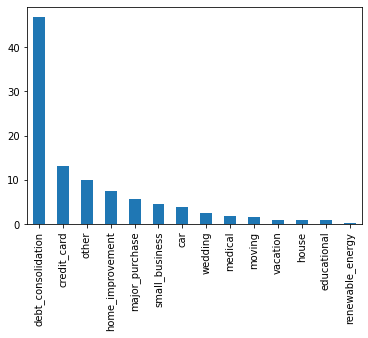

In [17]:
#Analysing the Purpose of loan
#find the % of purpose column and rounding up to 2 decimal places
purpose = ((loan_data.purpose.value_counts()*100)/len(loan_data)).round(decimals = 2)
purpose.plot.bar()
plt.show()

#### Top 3 reasons for taking loan

In [18]:
# as we see top 3 constitutes of 65% of the reasons
purpose.head(3)

debt_consolidation    46.80
credit_card           13.03
other                 10.02
Name: purpose, dtype: float64

In [19]:
#Analysing Loan Status
loan_status = (loan_data.loan_status.value_counts()*100)/len(loan_data)
loan_status

Fully Paid     85.413588
Charged Off    14.586412
Name: loan_status, dtype: float64

##### 85.4% of the loan is good loan and 14.5% is charged off or say bad loan

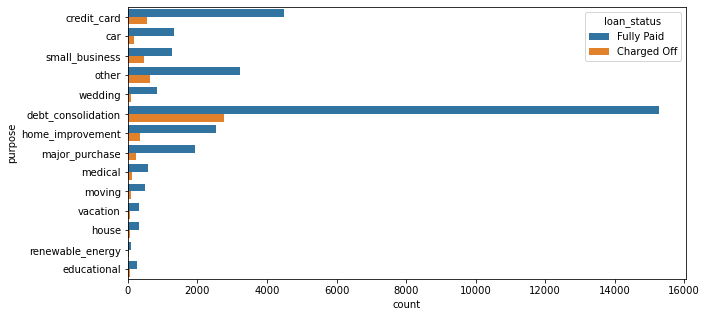

In [20]:
plt.figure(figsize=(10,5))
sns.countplot(y="purpose",data=loan_data,hue='loan_status')
plt.show()

In [21]:
#Univeriate Analysis on total payment made for the loan
loan_data.total_pymnt.describe()

count    38577.000000
mean     11866.970365
std       8809.856227
min          0.000000
25%       5513.497338
50%       9674.048405
75%      16136.952430
max      58563.679930
Name: total_pymnt, dtype: float64

C:\Users\Anurag\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


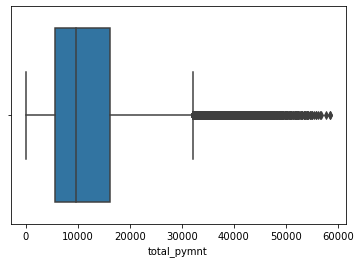

In [22]:
sns.boxplot(loan_data.total_pymnt)
plt.show()

In [23]:
#Analysisng inteest rate
# sns.boxplot(loan_data.int_rate)
# plt.show()

In [24]:
#Analysis on Loan amount
loan_data.loan_amnt.describe()

count    38577.000000
mean     11047.025430
std       7348.441646
min        500.000000
25%       5300.000000
50%       9600.000000
75%      15000.000000
max      35000.000000
Name: loan_amnt, dtype: float64

C:\Users\Anurag\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


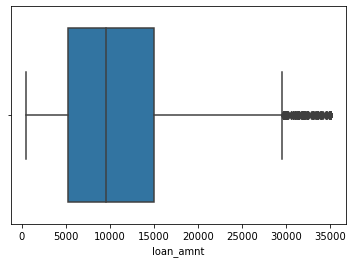

In [25]:
sns.boxplot(loan_data.loan_amnt)
plt.show()

C:\Users\Anurag\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


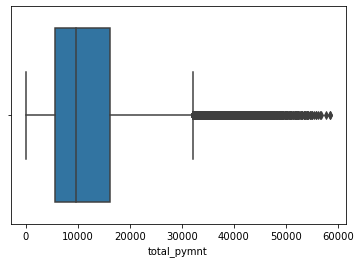

In [26]:
#Box plot of total payment
sns.boxplot(loan_data.total_pymnt)
plt.show()

C:\Users\Anurag\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


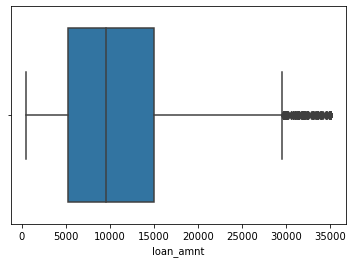

In [27]:
#Boxplot of Loan amount
sns.boxplot(loan_data.loan_amnt)
plt.show()

In [28]:
#annual income
loan_data.annual_inc.describe()

count    3.857700e+04
mean     6.877797e+04
std      6.421868e+04
min      4.000000e+03
25%      4.000000e+04
50%      5.886800e+04
75%      8.200000e+04
max      6.000000e+06
Name: annual_inc, dtype: float64

C:\Users\Anurag\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


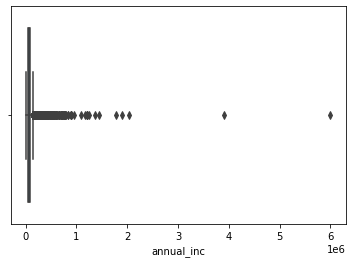

In [29]:
sns.boxplot(loan_data.annual_inc)
plt.show()

In [30]:
#We can clearly see couple of outliers
loan_data = loan_data[loan_data.annual_inc < loan_data.annual_inc.quantile(0.99)]

In [31]:
loan_data.annual_inc.describe()

count     38191.000000
mean      65313.610090
std       35150.773045
min        4000.000000
25%       40000.000000
50%       58000.000000
75%       80232.000000
max      234000.000000
Name: annual_inc, dtype: float64

##### We can see that the average salary is around 65k
###### Most of the salaries lie between 40k to 80k

C:\Users\Anurag\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Anurag\anaconda3\lib\site-packages\seaborn\distributions.py:2056: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)


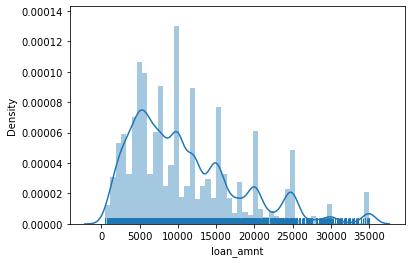

In [32]:
sns.distplot(loan_data.loan_amnt,rug = True)
plt.show()

#### Majorly the loan loans are funded between 5k to 15k but there is a huge spike for 10k loan

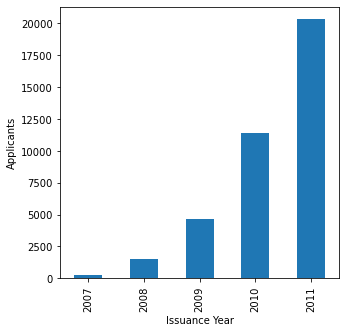

In [33]:
#Analysis on amount of loan issued year on yearr basis
plt.figure(figsize=(5, 5))
loan_data.groupby(['Year']).id.count().plot(kind='bar')
plt.xlabel('Issuance Year') 
plt.ylabel('Applicants')
plt.show()

##### there is a good amount of loan request per year

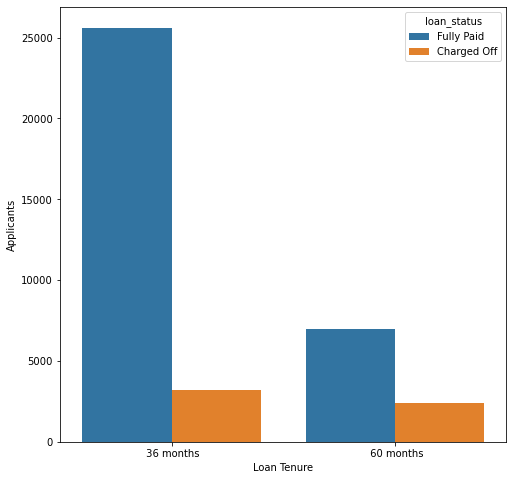

In [34]:
#Repayment term analysis
plt.figure(figsize=(8, 8))
sns.countplot(x="term",data=loan_data,hue='loan_status')
plt.xlabel('Loan Tenure')
plt.ylabel('Applicants')      
plt.show()

#### Here we can clearly see that there is huge risk of Charre off on a 60 months loan, where as those who have taken for 36 months have a better chance of pay off

### Bivariate Analysis

In [35]:
#Creating range for the Categorical Variables

loan_data['Loan_amnt_range'] = pd.cut(loan_data['loan_amnt'], [0, 7000, 14000, 21000, 28000, 35000], labels=['0-7000', '7000-14000', '14000-21000', '21000-28000', '28000 +'])
loan_data['Annual_income_range'] = pd.cut(loan_data['annual_inc'], [0, 20000, 40000, 60000, 80000,1000000], labels=['0-20000', '20000-40000', '40000-60000', '60000-80000', '80000 +'])

In [36]:
#Analysing the relation between Annual Income and Charge Off
Annual_Income_Vs_Charge_Off = loan_data.groupby(['Annual_income_range', 'loan_status']).loan_status.count().unstack().fillna(0).reset_index()
Annual_Income_Vs_Charge_Off['Total'] = Annual_Income_Vs_Charge_Off['Charged Off'] + Annual_Income_Vs_Charge_Off['Fully Paid'] 
Annual_Income_Vs_Charge_Off['Chargedoff_Proportion'] = Annual_Income_Vs_Charge_Off['Charged Off'] / Annual_Income_Vs_Charge_Off['Total']
Annual_Income_Vs_Charge_Off.sort_values('Chargedoff_Proportion', ascending=False)

loan_status,Annual_income_range,Charged Off,Fully Paid,Total,Chargedoff_Proportion
0,0-20000,237,943,1180,0.200847
1,20000-40000,1514,7004,8518,0.177741
2,40000-60000,1729,9534,11263,0.153511
3,60000-80000,1024,6597,7621,0.134366
4,80000 +,1080,8529,9609,0.112395


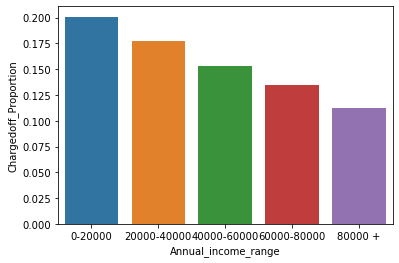

In [37]:
sns.barplot(x='Annual_income_range', y='Chargedoff_Proportion', data=Annual_Income_Vs_Charge_Off)
plt.show()

#### With this plot we can conclude that those with the higher salary bracket have a lesser chance to Default

In [38]:
#Analysing the relation between Purpose of loan and Loan amount
Purpose_Vs_Charge_Off=loan_data.groupby(['purpose', 'loan_status']).loan_status.count().unstack().fillna(0).reset_index()
Purpose_Vs_Charge_Off['Total'] =Purpose_Vs_Charge_Off['Charged Off']+Purpose_Vs_Charge_Off['Fully Paid'] 
Purpose_Vs_Charge_Off['Chargedoff_Proportion']=Purpose_Vs_Charge_Off['Charged Off']/Purpose_Vs_Charge_Off['Total']
Purpose_Vs_Charge_Off.sort_values('Chargedoff_Proportion',ascending=False)

loan_status,purpose,Charged Off,Fully Paid,Total,Chargedoff_Proportion
11,small_business,472,1251,1723,0.273941
10,renewable_energy,19,81,100,0.190000
3,educational,55,268,323,0.170279
9,other,629,3202,3831,0.164187
5,house,58,299,357,0.162465
8,moving,91,479,570,0.159649
7,medical,106,568,674,0.157270
2,debt_consolidation,2752,15165,17917,0.153597
12,vacation,53,322,375,0.141333
4,home_improvement,338,2459,2797,0.120844


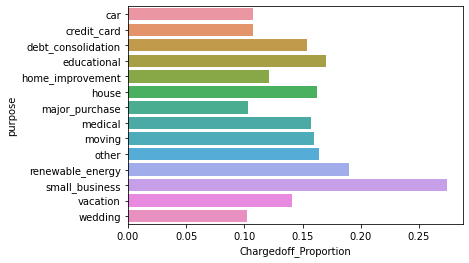

In [39]:
#
sns.barplot(y='purpose' ,x='Chargedoff_Proportion' ,data=Purpose_Vs_Charge_Off)
# plt.yticks(rotation=45)
plt.show()

#### Above plot clearly states that the small bussiness have the high charge off rate, so there are high chances of a "Small Business" doing a default
##### Where as loan taken for "Wedding" has the lease charge off, so it is having a very high chances of getting paid

In [40]:
#Analysing Epmloyment length with Charge off

Employ_Len_Vs_Charge_Off = loan_data.groupby(['emp_length', 'loan_status']).loan_status.count().unstack().fillna(0).reset_index()
Employ_Len_Vs_Charge_Off['Total'] = Employ_Len_Vs_Charge_Off['Charged Off']+Employ_Len_Vs_Charge_Off['Fully Paid'] 
Employ_Len_Vs_Charge_Off['Chargedoff_Proportion'] = Employ_Len_Vs_Charge_Off['Charged Off']/Employ_Len_Vs_Charge_Off['Total']
Employ_Len_Vs_Charge_Off.sort_values('Chargedoff_Proportion', ascending=False)

loan_status,emp_length,Charged Off,Fully Paid,Total,Chargedoff_Proportion
0,0,227,801,1028,0.220817
2,10,1316,7038,8354,0.157529
8,7,262,1435,1697,0.154390
6,5,456,2712,3168,0.143939
9,8,203,1216,1419,0.143058
1,1,1090,6532,7622,0.143007
7,6,305,1846,2151,0.141795
4,3,551,3426,3977,0.138547
5,4,456,2859,3315,0.137557
3,2,561,3684,4245,0.132155


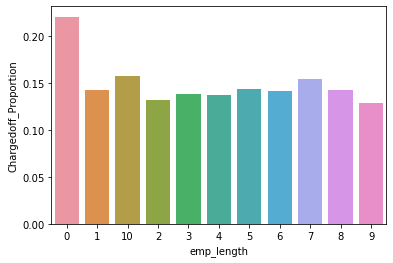

In [41]:
sns.barplot(x='emp_length', y='Chargedoff_Proportion' ,data=Employ_Len_Vs_Charge_Off)
plt.show()

In [42]:
#Analysing Bankruptcy data
Bankruptcy_data = loan_data.groupby(['pub_rec_bankruptcies', 'loan_status']).loan_status.count().unstack().fillna(0).reset_index()
Bankruptcy_data['Total']=Bankruptcy_data['Charged Off']+Bankruptcy_data['Fully Paid'] 
Bankruptcy_data['Chargedoff_Proportion'] =Bankruptcy_data['Charged Off']/Bankruptcy_data['Total']
Bankruptcy_data.sort_values('Chargedoff_Proportion', ascending=False)

loan_status,pub_rec_bankruptcies,Charged Off,Fully Paid,Total,Chargedoff_Proportion
2,2.0,2,3,5,0.400000
1,1.0,365,1268,1633,0.223515
3,No_Data,116,572,688,0.168605
0,0.0,5101,30764,35865,0.142228


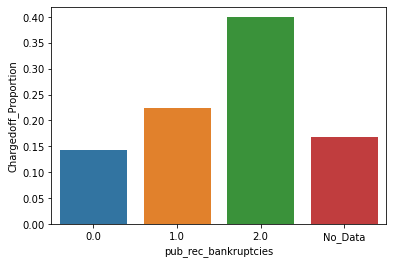

In [43]:
sns.barplot(x='pub_rec_bankruptcies',y='Chargedoff_Proportion', data=Bankruptcy_data)
plt.show()

##### Those who are unepmloyeed or have the numbers of years of experience less than 1 year have a very high chance of Default

In [44]:
#Analysing State wise Vs Charge Off data
State_Vs_Charge_Off = loan_data.groupby(['addr_state', 'loan_status']).loan_status.count().unstack().fillna(0).reset_index()
State_Vs_Charge_Off['Total'] =State_Vs_Charge_Off['Charged Off']+State_Vs_Charge_Off['Fully Paid'] 
State_Vs_Charge_Off['Chargedoff_Proportion'] = State_Vs_Charge_Off['Charged Off']/State_Vs_Charge_Off['Total']
State_Vs_Charge_Off.sort_values('Chargedoff_Proportion', ascending=False)

loan_status,addr_state,Charged Off,Fully Paid,Total,Chargedoff_Proportion
28,NE,3.0,2.0,5.0,0.600000
32,NV,107.0,368.0,475.0,0.225263
40,SD,12.0,50.0,62.0,0.193548
0,AK,14.0,63.0,77.0,0.181818
9,FL,497.0,2252.0,2749.0,0.180793
24,MO,114.0,551.0,665.0,0.171429
11,HI,28.0,138.0,166.0,0.168675
31,NM,30.0,149.0,179.0,0.167598
13,ID,1.0,5.0,6.0,0.166667
36,OR,71.0,364.0,435.0,0.163218


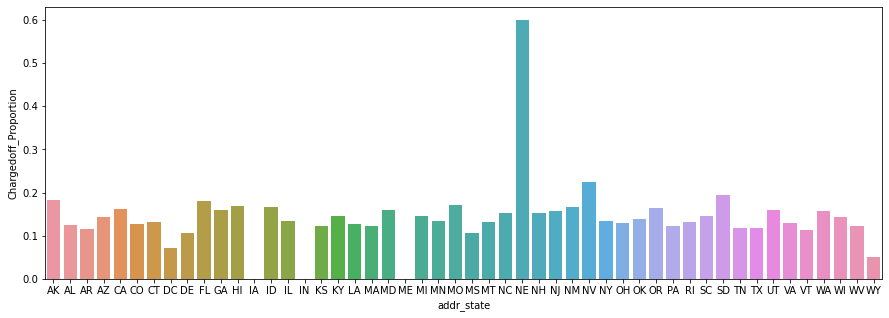

In [45]:
plt.figure(figsize=(15,5))
sns.barplot(x='addr_state', y='Chargedoff_Proportion', data=State_Vs_Charge_Off)
plt.show()

##### State "NE" has a dramatically 3 times higher charge off rate as compared to the other states.
##### Providing loans to this state must be avoided or if planned there should be strict background check.